# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.382243  0.991475  1.0  0.206732  1.145190  0.076025  3  2  39.085472   
1  1.476683 -0.592094  1.0  0.376048  1.882426 -0.980310  0  3  35.573172   
2 -1.562621  1.838967  0.0  0.350499 -0.299166  1.937209  3  3  35.756795   
3 -2.064697  0.089614  1.0  0.840634  0.221479 -0.035227  3  1  37.917550   
4  2.365069  1.034220  1.0  0.236689  0.401850  0.795102  3  0  26.794251   

            y  
0  495.085704  
1  450.412672  
2  441.029349  
3  185.694594  
4  542.241218  
True causal estimate is 10.149811991745088


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

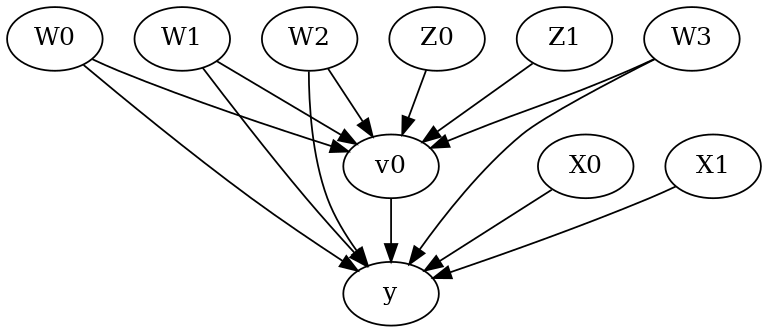

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W2,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W3,W1,U) = P(y|v0,W0,W2,W3,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression


{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X1', 'X0']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W2,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W3,W1,U) = P(y|v0,W0,W2,W3,W1)

## Realized estimand
b: y~v0+W0+W2+W3+W1+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 10.14968340700062
### Conditional Estimates
__categorical__X1              __categorical__X0
(-3.2119999999999997, -0.365]  (-4.357, -1.376]      1.724676
                               (-1.376, -0.789]      4.129946
                               (-0.789, -0.279]      5.515634
                               (-0.279, 0.313]       6.960274
                               (0.313, 3.202]        9.475677
(-0.365, 0.246]                (-4.357, -1.376]      4.552917
                               (-1.376, -0.789]      6.945755
                               (-0.789, -0.279]     

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W2,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W3,W1,U) = P(y|v0,W0,W2,W3,W1)

## Realized estimand
b: y~v0+W0+W2+W3+W1 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 15.579542269360367
Effect estimates: [12.04194737 19.87955648 16.45303569 10.99711537 17.69945502 13.12717595
 12.97918218 17.41161738 15.55868853 18.09832105 17.75989882 22.59958547
 16.88120728 13.76197925 13.87903083 11.31595155 13.60913166 21.52923519
 12.78768649 21.65087054 21.50538016 14.56335904 16.85412929 12.01587838
  6.75827109 15.22339122 18.56561313 13.72871195 15.0571822  15.44232312
 13.25356778 12.64904796 12.5212654  14.07428712 16.24244906 15.90227669
 21.06452955 17.53617647 23.84572761 22.22411879 12.66479821 23.3491633
 19.44

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 10.149811991745088


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W2,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W3,W1,U) = P(y|v0,W0,W2,W3,W1)

## Realized estimand
b: y~v0+W0+W2+W3+W1 | X1,X0
Target units: 

## Estimate
Mean value: 10.107954593525895
Effect estimates: [12.13535307 11.93762473 11.74042472 ...  9.22414337  7.55268368
 10.89966031]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W2,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W3,W1,U) = P(y|v0,W0,W2,W3,W1)

## Realized estimand
b: y~v0+W0+W2+W3+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 10.18581523102118
Effect estimates: [12.29750957 12.06429161 11.90291879 ...  9.27225506  7.51612875
 10.99685573]
95.0% confidence interval: (array([12.45468369, 12.06601082, 12.02754355, ...,  9.3538886 ,
        7.44297302, 11.07058064]), array([12.74350908, 12.58355226, 12.39629981, ...,  9.53555168,
        7.68072677, 11.37256003]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[10.78296491 13.4799205  13.05724887 14.82730146 11.06575109 12.42535399
 12.02527916 12.08440521 12.3030505  15.64654241]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     0.802224 -1.394659  0.0  0.374045 -0.125728 -0.840551 -0.417808   
1     0.609587 -1.276728  1.0  0.554231  0.199378 -0.278654 -1.179958   
2    -0.359818  0.562743  1.0  0.736803  0.721472  0.983868  0.270438   
3    -0.578285 -0.545951  1.0  0.796351 -0.297671  1.788919  1.015632   
4     0.532123 -0.807892  1.0  0.425232 -0.033569  1.378460  2.562025   
...        ...       ...  ...       ...       ...       ...       ...   
9995  0.653115 -1.700657  1.0  0.021834  1.529886 -0.787037  0.559244   
9996  1.487856  1.078057  1.0  0.790368 -1.101316  0.034803  0.568823   
9997 -0.189503 -2.405444  0.0  0.908974 -0.304509  0.980447  0.774667   
9998  0.897027  0.162917  1.0  0.796251  0.978622 -1.007607  1.713114   
9999  0.611938 -2.095426  0.0  0.588390 -0.106102  1.332279 -0.011111   

            W3  v0  y  
0    -0.716999   0  0  
1    -0.591947   1  1  
2     0.325974   1  1  
3    -2.204970   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W2,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W3,W1,U) = P(y|v0,W0,W2,W3,W1)

## Realized estimand
b: y~v0+W0+W2+W3+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 0.6387274746732261
Effect estimates: [0.65279505 0.64451996 0.64421802 ... 0.5565136  0.71047112 0.61750554]

True causal estimate is 0.3532


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-08-13 01:30:13.238565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-13 01:30:13.238602: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-08-13 01:30:14.951147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-13 01:30:14.951189: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-13 01:30:14.951215: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (97863b237cd7): /proc/driver/nvidia/version does not exist
2022-08-13 01:30:14.951489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 3:10 - loss: 292.4737

 32/313 [==>...........................] - ETA: 0s - loss: 88.3483   

 63/313 [=====>........................] - ETA: 0s - loss: 48.0638

 96/313 [========>.....................] - ETA: 0s - loss: 33.3573

129/313 [===========>..................] - ETA: 0s - loss: 26.1380

162/313 [==============>...............] - ETA: 0s - loss: 21.8473

195/313 [=================>............] - ETA: 0s - loss: 18.9974

225/313 [====================>.........] - ETA: 0s - loss: 17.1166

253/313 [=======================>......] - ETA: 0s - loss: 15.7576

284/313 [==========================>...] - ETA: 0s - loss: 14.5637

313/313 [==============================] - 1s 2ms/step - loss: 13.6539


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 4.7010

 32/313 [==>...........................] - ETA: 0s - loss: 4.7298

 63/313 [=====>........................] - ETA: 0s - loss: 4.6547

 94/313 [========>.....................] - ETA: 0s - loss: 4.6442

126/313 [===========>..................] - ETA: 0s - loss: 4.6026

158/313 [==============>...............] - ETA: 0s - loss: 4.5727

190/313 [=================>............] - ETA: 0s - loss: 4.5455

222/313 [====================>.........] - ETA: 0s - loss: 4.5240

254/313 [=======================>......] - ETA: 0s - loss: 4.5060

284/313 [==========================>...] - ETA: 0s - loss: 4.4882

313/313 [==============================] - 1s 2ms/step - loss: 4.4751


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 4.3586

 33/313 [==>...........................] - ETA: 0s - loss: 4.2614

 62/313 [====>.........................] - ETA: 0s - loss: 4.2662

 93/313 [=======>......................] - ETA: 0s - loss: 4.2605

125/313 [==========>...................] - ETA: 0s - loss: 4.2510

156/313 [=============>................] - ETA: 0s - loss: 4.2478

187/313 [================>.............] - ETA: 0s - loss: 4.2323

220/313 [====================>.........] - ETA: 0s - loss: 4.2216

252/313 [=======================>......] - ETA: 0s - loss: 4.2087

283/313 [==========================>...] - ETA: 0s - loss: 4.1960

313/313 [==============================] - 1s 2ms/step - loss: 4.1839


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 3.8884

 32/313 [==>...........................] - ETA: 0s - loss: 3.9613

 62/313 [====>.........................] - ETA: 0s - loss: 3.9454

 92/313 [=======>......................] - ETA: 0s - loss: 3.9016

123/313 [==========>...................] - ETA: 0s - loss: 3.8347

154/313 [=============>................] - ETA: 0s - loss: 3.7669

185/313 [================>.............] - ETA: 0s - loss: 3.7065

216/313 [===================>..........] - ETA: 0s - loss: 3.6492

247/313 [======================>.......] - ETA: 0s - loss: 3.6065

279/313 [=========================>....] - ETA: 0s - loss: 3.5668

311/313 [============================>.] - ETA: 0s - loss: 3.5321

313/313 [==============================] - 1s 2ms/step - loss: 3.5316


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 3.2298

 33/313 [==>...........................] - ETA: 0s - loss: 3.1892

 64/313 [=====>........................] - ETA: 0s - loss: 3.1934

 95/313 [========>.....................] - ETA: 0s - loss: 3.1951

127/313 [===========>..................] - ETA: 0s - loss: 3.2000

158/313 [==============>...............] - ETA: 0s - loss: 3.1885

190/313 [=================>............] - ETA: 0s - loss: 3.1757

222/313 [====================>.........] - ETA: 0s - loss: 3.1691

254/313 [=======================>......] - ETA: 0s - loss: 3.1670

286/313 [==========================>...] - ETA: 0s - loss: 3.1635

313/313 [==============================] - 1s 2ms/step - loss: 3.1623


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 2.8155

 33/313 [==>...........................] - ETA: 0s - loss: 3.0360

 64/313 [=====>........................] - ETA: 0s - loss: 3.0645

 95/313 [========>.....................] - ETA: 0s - loss: 3.0443

125/313 [==========>...................] - ETA: 0s - loss: 3.0479

156/313 [=============>................] - ETA: 0s - loss: 3.0500

186/313 [================>.............] - ETA: 0s - loss: 3.0416

218/313 [===================>..........] - ETA: 0s - loss: 3.0463

250/313 [======================>.......] - ETA: 0s - loss: 3.0445

282/313 [==========================>...] - ETA: 0s - loss: 3.0442

313/313 [==============================] - ETA: 0s - loss: 3.0400

313/313 [==============================] - 1s 2ms/step - loss: 3.0400


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.9216

 34/313 [==>...........................] - ETA: 0s - loss: 2.9737

 66/313 [=====>........................] - ETA: 0s - loss: 2.9951

 97/313 [========>.....................] - ETA: 0s - loss: 2.9788

129/313 [===========>..................] - ETA: 0s - loss: 2.9846

161/313 [==============>...............] - ETA: 0s - loss: 2.9778

193/313 [=================>............] - ETA: 0s - loss: 2.9803

225/313 [====================>.........] - ETA: 0s - loss: 2.9826

256/313 [=======================>......] - ETA: 0s - loss: 2.9755

288/313 [==========================>...] - ETA: 0s - loss: 2.9718

313/313 [==============================] - 1s 2ms/step - loss: 2.9718


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.7695

 33/313 [==>...........................] - ETA: 0s - loss: 2.8918

 65/313 [=====>........................] - ETA: 0s - loss: 2.8927

 94/313 [========>.....................] - ETA: 0s - loss: 2.9008

123/313 [==========>...................] - ETA: 0s - loss: 2.9063

152/313 [=============>................] - ETA: 0s - loss: 2.9038

182/313 [================>.............] - ETA: 0s - loss: 2.9021

212/313 [===================>..........] - ETA: 0s - loss: 2.9100

242/313 [======================>.......] - ETA: 0s - loss: 2.9026

271/313 [========================>.....] - ETA: 0s - loss: 2.8943

301/313 [===========================>..] - ETA: 0s - loss: 2.8936

313/313 [==============================] - 1s 2ms/step - loss: 2.8913


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.8482

 33/313 [==>...........................] - ETA: 0s - loss: 2.8802

 65/313 [=====>........................] - ETA: 0s - loss: 2.8746

 97/313 [========>.....................] - ETA: 0s - loss: 2.8903

128/313 [===========>..................] - ETA: 0s - loss: 2.8929

159/313 [==============>...............] - ETA: 0s - loss: 2.8885

190/313 [=================>............] - ETA: 0s - loss: 2.8811

221/313 [====================>.........] - ETA: 0s - loss: 2.8817

253/313 [=======================>......] - ETA: 0s - loss: 2.8737

283/313 [==========================>...] - ETA: 0s - loss: 2.8746

313/313 [==============================] - 1s 2ms/step - loss: 2.8717


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.7093

 33/313 [==>...........................] - ETA: 0s - loss: 2.8623

 64/313 [=====>........................] - ETA: 0s - loss: 2.8614

 94/313 [========>.....................] - ETA: 0s - loss: 2.8610

124/313 [==========>...................] - ETA: 0s - loss: 2.8443

155/313 [=============>................] - ETA: 0s - loss: 2.8448

186/313 [================>.............] - ETA: 0s - loss: 2.8455

216/313 [===================>..........] - ETA: 0s - loss: 2.8468

248/313 [======================>.......] - ETA: 0s - loss: 2.8478

279/313 [=========================>....] - ETA: 0s - loss: 2.8454

310/313 [============================>.] - ETA: 0s - loss: 2.8491

313/313 [==============================] - 1s 2ms/step - loss: 2.8482


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.7128

 32/313 [==>...........................] - ETA: 0s - loss: 2.8864

 61/313 [====>.........................] - ETA: 0s - loss: 2.8610

 91/313 [=======>......................] - ETA: 0s - loss: 2.8474

122/313 [==========>...................] - ETA: 0s - loss: 2.8428

154/313 [=============>................] - ETA: 0s - loss: 2.8413

185/313 [================>.............] - ETA: 0s - loss: 2.8401

217/313 [===================>..........] - ETA: 0s - loss: 2.8286

249/313 [======================>.......] - ETA: 0s - loss: 2.8266

281/313 [=========================>....] - ETA: 0s - loss: 2.8275

312/313 [============================>.] - ETA: 0s - loss: 2.8265

313/313 [==============================] - 1s 2ms/step - loss: 2.8269


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 3.0027

 31/313 [=>............................] - ETA: 0s - loss: 2.8294

 61/313 [====>.........................] - ETA: 0s - loss: 2.8208

 91/313 [=======>......................] - ETA: 0s - loss: 2.8326

123/313 [==========>...................] - ETA: 0s - loss: 2.8265

154/313 [=============>................] - ETA: 0s - loss: 2.8199

186/313 [================>.............] - ETA: 0s - loss: 2.8213

218/313 [===================>..........] - ETA: 0s - loss: 2.8206

249/313 [======================>.......] - ETA: 0s - loss: 2.8210

281/313 [=========================>....] - ETA: 0s - loss: 2.8181

313/313 [==============================] - ETA: 0s - loss: 2.8216

313/313 [==============================] - 1s 2ms/step - loss: 2.8216


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 2.7505

 31/313 [=>............................] - ETA: 0s - loss: 2.8274

 62/313 [====>.........................] - ETA: 0s - loss: 2.8075

 94/313 [========>.....................] - ETA: 0s - loss: 2.8170

125/313 [==========>...................] - ETA: 0s - loss: 2.8128

157/313 [==============>...............] - ETA: 0s - loss: 2.8165

189/313 [=================>............] - ETA: 0s - loss: 2.8111

221/313 [====================>.........] - ETA: 0s - loss: 2.8102

253/313 [=======================>......] - ETA: 0s - loss: 2.8045

285/313 [==========================>...] - ETA: 0s - loss: 2.8009

313/313 [==============================] - 1s 2ms/step - loss: 2.8001


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.7753

 33/313 [==>...........................] - ETA: 0s - loss: 2.8385

 65/313 [=====>........................] - ETA: 0s - loss: 2.8139

 97/313 [========>.....................] - ETA: 0s - loss: 2.8114

128/313 [===========>..................] - ETA: 0s - loss: 2.8162

160/313 [==============>...............] - ETA: 0s - loss: 2.8083

192/313 [=================>............] - ETA: 0s - loss: 2.8016

218/313 [===================>..........] - ETA: 0s - loss: 2.7999

240/313 [======================>.......] - ETA: 0s - loss: 2.7964

270/313 [========================>.....] - ETA: 0s - loss: 2.8000

301/313 [===========================>..] - ETA: 0s - loss: 2.7987

313/313 [==============================] - 1s 2ms/step - loss: 2.7991


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 2.6615

 33/313 [==>...........................] - ETA: 0s - loss: 2.7651

 63/313 [=====>........................] - ETA: 0s - loss: 2.7811

 95/313 [========>.....................] - ETA: 0s - loss: 2.7839

128/313 [===========>..................] - ETA: 0s - loss: 2.7911

160/313 [==============>...............] - ETA: 0s - loss: 2.7880

192/313 [=================>............] - ETA: 0s - loss: 2.7894

224/313 [====================>.........] - ETA: 0s - loss: 2.7875

256/313 [=======================>......] - ETA: 0s - loss: 2.7818

288/313 [==========================>...] - ETA: 0s - loss: 2.7838

313/313 [==============================] - 1s 2ms/step - loss: 2.7855


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 3.1738

 34/313 [==>...........................] - ETA: 0s - loss: 2.7825

 66/313 [=====>........................] - ETA: 0s - loss: 2.7832

 98/313 [========>.....................] - ETA: 0s - loss: 2.7817

131/313 [===========>..................] - ETA: 0s - loss: 2.7656

163/313 [==============>...............] - ETA: 0s - loss: 2.7741

196/313 [=================>............] - ETA: 0s - loss: 2.7767

226/313 [====================>.........] - ETA: 0s - loss: 2.7748

258/313 [=======================>......] - ETA: 0s - loss: 2.7729

290/313 [==========================>...] - ETA: 0s - loss: 2.7706

313/313 [==============================] - 0s 2ms/step - loss: 2.7740


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.8055

 34/313 [==>...........................] - ETA: 0s - loss: 2.7990

 67/313 [=====>........................] - ETA: 0s - loss: 2.7789

100/313 [========>.....................] - ETA: 0s - loss: 2.7760

131/313 [===========>..................] - ETA: 0s - loss: 2.7815

162/313 [==============>...............] - ETA: 0s - loss: 2.7847

194/313 [=================>............] - ETA: 0s - loss: 2.7876

226/313 [====================>.........] - ETA: 0s - loss: 2.7843

258/313 [=======================>......] - ETA: 0s - loss: 2.7823

290/313 [==========================>...] - ETA: 0s - loss: 2.7785

313/313 [==============================] - 0s 2ms/step - loss: 2.7770


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.8211

 34/313 [==>...........................] - ETA: 0s - loss: 2.7619

 66/313 [=====>........................] - ETA: 0s - loss: 2.7373

 98/313 [========>.....................] - ETA: 0s - loss: 2.7561

131/313 [===========>..................] - ETA: 0s - loss: 2.7667

164/313 [==============>...............] - ETA: 0s - loss: 2.7631

196/313 [=================>............] - ETA: 0s - loss: 2.7633

228/313 [====================>.........] - ETA: 0s - loss: 2.7627

260/313 [=======================>......] - ETA: 0s - loss: 2.7606

292/313 [==========================>...] - ETA: 0s - loss: 2.7637

313/313 [==============================] - 0s 2ms/step - loss: 2.7634


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.6941

 33/313 [==>...........................] - ETA: 0s - loss: 2.7846

 64/313 [=====>........................] - ETA: 0s - loss: 2.7713

 96/313 [========>.....................] - ETA: 0s - loss: 2.7589

129/313 [===========>..................] - ETA: 0s - loss: 2.7472

162/313 [==============>...............] - ETA: 0s - loss: 2.7552

194/313 [=================>............] - ETA: 0s - loss: 2.7575

227/313 [====================>.........] - ETA: 0s - loss: 2.7575

259/313 [=======================>......] - ETA: 0s - loss: 2.7595

292/313 [==========================>...] - ETA: 0s - loss: 2.7626

313/313 [==============================] - 0s 2ms/step - loss: 2.7587


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.9276

 34/313 [==>...........................] - ETA: 0s - loss: 2.7737

 66/313 [=====>........................] - ETA: 0s - loss: 2.7586

 98/313 [========>.....................] - ETA: 0s - loss: 2.7606

130/313 [===========>..................] - ETA: 0s - loss: 2.7661

162/313 [==============>...............] - ETA: 0s - loss: 2.7679

195/313 [=================>............] - ETA: 0s - loss: 2.7587

228/313 [====================>.........] - ETA: 0s - loss: 2.7605

259/313 [=======================>......] - ETA: 0s - loss: 2.7581

291/313 [==========================>...] - ETA: 0s - loss: 2.7571

313/313 [==============================] - 0s 2ms/step - loss: 2.7556


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.8399

 34/313 [==>...........................] - ETA: 0s - loss: 2.7657

 65/313 [=====>........................] - ETA: 0s - loss: 2.7715

 96/313 [========>.....................] - ETA: 0s - loss: 2.7590

128/313 [===========>..................] - ETA: 0s - loss: 2.7540

159/313 [==============>...............] - ETA: 0s - loss: 2.7502

190/313 [=================>............] - ETA: 0s - loss: 2.7484

221/313 [====================>.........] - ETA: 0s - loss: 2.7489

253/313 [=======================>......] - ETA: 0s - loss: 2.7472

284/313 [==========================>...] - ETA: 0s - loss: 2.7441

313/313 [==============================] - 1s 2ms/step - loss: 2.7459


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.7595

 33/313 [==>...........................] - ETA: 0s - loss: 2.7613

 64/313 [=====>........................] - ETA: 0s - loss: 2.7638

 95/313 [========>.....................] - ETA: 0s - loss: 2.7665

127/313 [===========>..................] - ETA: 0s - loss: 2.7641

159/313 [==============>...............] - ETA: 0s - loss: 2.7542

191/313 [=================>............] - ETA: 0s - loss: 2.7543

222/313 [====================>.........] - ETA: 0s - loss: 2.7510

254/313 [=======================>......] - ETA: 0s - loss: 2.7574

286/313 [==========================>...] - ETA: 0s - loss: 2.7513

313/313 [==============================] - 1s 2ms/step - loss: 2.7505


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.8173

 33/313 [==>...........................] - ETA: 0s - loss: 2.7459

 64/313 [=====>........................] - ETA: 0s - loss: 2.7183

 96/313 [========>.....................] - ETA: 0s - loss: 2.7305

128/313 [===========>..................] - ETA: 0s - loss: 2.7269

159/313 [==============>...............] - ETA: 0s - loss: 2.7323

191/313 [=================>............] - ETA: 0s - loss: 2.7311

223/313 [====================>.........] - ETA: 0s - loss: 2.7283

255/313 [=======================>......] - ETA: 0s - loss: 2.7317

286/313 [==========================>...] - ETA: 0s - loss: 2.7330

313/313 [==============================] - 1s 2ms/step - loss: 2.7346


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2.6829

 33/313 [==>...........................] - ETA: 0s - loss: 2.7271

 65/313 [=====>........................] - ETA: 0s - loss: 2.7260

 98/313 [========>.....................] - ETA: 0s - loss: 2.7287

128/313 [===========>..................] - ETA: 0s - loss: 2.7271

161/313 [==============>...............] - ETA: 0s - loss: 2.7238

194/313 [=================>............] - ETA: 0s - loss: 2.7293

226/313 [====================>.........] - ETA: 0s - loss: 2.7322

259/313 [=======================>......] - ETA: 0s - loss: 2.7313

290/313 [==========================>...] - ETA: 0s - loss: 2.7302

313/313 [==============================] - 0s 2ms/step - loss: 2.7324


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.6559

 34/313 [==>...........................] - ETA: 0s - loss: 2.7346

 66/313 [=====>........................] - ETA: 0s - loss: 2.7360

 98/313 [========>.....................] - ETA: 0s - loss: 2.7386

130/313 [===========>..................] - ETA: 0s - loss: 2.7325

162/313 [==============>...............] - ETA: 0s - loss: 2.7382

195/313 [=================>............] - ETA: 0s - loss: 2.7338

227/313 [====================>.........] - ETA: 0s - loss: 2.7304

259/313 [=======================>......] - ETA: 0s - loss: 2.7321

291/313 [==========================>...] - ETA: 0s - loss: 2.7312

313/313 [==============================] - 0s 2ms/step - loss: 2.7286


Epoch 1/25


  1/313 [..............................] - ETA: 3:42 - loss: 121781.7734

 27/313 [=>............................] - ETA: 0s - loss: 111669.7891  

 53/313 [====>.........................] - ETA: 0s - loss: 85163.0156 

 77/313 [======>.......................] - ETA: 0s - loss: 70716.5547

102/313 [========>.....................] - ETA: 0s - loss: 62648.4258

128/313 [===========>..................] - ETA: 0s - loss: 57165.0781

153/313 [=============>................] - ETA: 0s - loss: 53478.5000

178/313 [================>.............] - ETA: 0s - loss: 50728.5156

205/313 [==================>...........] - ETA: 0s - loss: 47940.4922

231/313 [=====================>........] - ETA: 0s - loss: 46016.8086

256/313 [=======================>......] - ETA: 0s - loss: 44423.6914

281/313 [=========================>....] - ETA: 0s - loss: 42970.1992

306/313 [============================>.] - ETA: 0s - loss: 41394.6211

313/313 [==============================] - 1s 2ms/step - loss: 40999.5117


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 44719.5312

 27/313 [=>............................] - ETA: 0s - loss: 22990.7363

 52/313 [===>..........................] - ETA: 0s - loss: 21331.8574

 77/313 [======>.......................] - ETA: 0s - loss: 20672.2578

101/313 [========>.....................] - ETA: 0s - loss: 20431.0176

126/313 [===========>..................] - ETA: 0s - loss: 19840.8262

150/313 [=============>................] - ETA: 0s - loss: 19581.5605

175/313 [===============>..............] - ETA: 0s - loss: 19324.6934

199/313 [==================>...........] - ETA: 0s - loss: 19165.4258

224/313 [====================>.........] - ETA: 0s - loss: 18970.1895

251/313 [=======================>......] - ETA: 0s - loss: 18788.6270

275/313 [=========================>....] - ETA: 0s - loss: 18726.5918

300/313 [===========================>..] - ETA: 0s - loss: 18527.2832

313/313 [==============================] - 1s 2ms/step - loss: 18498.4688


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 13244.1924

 27/313 [=>............................] - ETA: 0s - loss: 17171.2227

 52/313 [===>..........................] - ETA: 0s - loss: 17182.7832

 77/313 [======>.......................] - ETA: 0s - loss: 16995.4453

102/313 [========>.....................] - ETA: 0s - loss: 16677.0352

128/313 [===========>..................] - ETA: 0s - loss: 16631.3750

154/313 [=============>................] - ETA: 0s - loss: 16597.6895

180/313 [================>.............] - ETA: 0s - loss: 16652.4961

207/313 [==================>...........] - ETA: 0s - loss: 16776.5996

233/313 [=====================>........] - ETA: 0s - loss: 16635.5137

259/313 [=======================>......] - ETA: 0s - loss: 16499.1035

285/313 [==========================>...] - ETA: 0s - loss: 16482.0020

310/313 [============================>.] - ETA: 0s - loss: 16453.1738

313/313 [==============================] - 1s 2ms/step - loss: 16478.2598


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 18393.1797

 26/313 [=>............................] - ETA: 0s - loss: 15293.3867

 50/313 [===>..........................] - ETA: 0s - loss: 15454.9453

 76/313 [======>.......................] - ETA: 0s - loss: 15774.5869

102/313 [========>.....................] - ETA: 0s - loss: 15825.2080

128/313 [===========>..................] - ETA: 0s - loss: 15599.9980

155/313 [=============>................] - ETA: 0s - loss: 15696.3838

181/313 [================>.............] - ETA: 0s - loss: 15515.8174

208/313 [==================>...........] - ETA: 0s - loss: 15548.0762

235/313 [=====================>........] - ETA: 0s - loss: 15744.7041

262/313 [========================>.....] - ETA: 0s - loss: 15613.0859

289/313 [==========================>...] - ETA: 0s - loss: 15681.5420

313/313 [==============================] - 1s 2ms/step - loss: 15742.8389


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 13541.9805

 27/313 [=>............................] - ETA: 0s - loss: 16463.3496

 52/313 [===>..........................] - ETA: 0s - loss: 16215.4941

 78/313 [======>.......................] - ETA: 0s - loss: 16377.5850

104/313 [========>.....................] - ETA: 0s - loss: 15960.0762

130/313 [===========>..................] - ETA: 0s - loss: 16027.3398

157/313 [==============>...............] - ETA: 0s - loss: 16073.9014

183/313 [================>.............] - ETA: 0s - loss: 15777.2061

209/313 [===================>..........] - ETA: 0s - loss: 15859.0088

236/313 [=====================>........] - ETA: 0s - loss: 15822.9492

263/313 [========================>.....] - ETA: 0s - loss: 15870.1865

290/313 [==========================>...] - ETA: 0s - loss: 15806.5342

313/313 [==============================] - 1s 2ms/step - loss: 15820.9043


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 19764.4805

 27/313 [=>............................] - ETA: 0s - loss: 15603.4023

 53/313 [====>.........................] - ETA: 0s - loss: 16085.8164

 80/313 [======>.......................] - ETA: 0s - loss: 15874.7969

106/313 [=========>....................] - ETA: 0s - loss: 15629.4668

132/313 [===========>..................] - ETA: 0s - loss: 15511.4160

158/313 [==============>...............] - ETA: 0s - loss: 15621.6689

184/313 [================>.............] - ETA: 0s - loss: 15556.6357

210/313 [===================>..........] - ETA: 0s - loss: 15770.3057

235/313 [=====================>........] - ETA: 0s - loss: 15740.1318

261/313 [========================>.....] - ETA: 0s - loss: 15567.1074

287/313 [==========================>...] - ETA: 0s - loss: 15517.0508

313/313 [==============================] - 1s 2ms/step - loss: 15484.1787


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 11299.6162

 28/313 [=>............................] - ETA: 0s - loss: 16602.2812

 55/313 [====>.........................] - ETA: 0s - loss: 15659.1396

 79/313 [======>.......................] - ETA: 0s - loss: 15726.4053

104/313 [========>.....................] - ETA: 0s - loss: 15665.2607

130/313 [===========>..................] - ETA: 0s - loss: 15954.9150

155/313 [=============>................] - ETA: 0s - loss: 15811.5400

181/313 [================>.............] - ETA: 0s - loss: 15765.3311

207/313 [==================>...........] - ETA: 0s - loss: 15606.5020

233/313 [=====================>........] - ETA: 0s - loss: 15546.3076

259/313 [=======================>......] - ETA: 0s - loss: 15583.7578

285/313 [==========================>...] - ETA: 0s - loss: 15518.5068

311/313 [============================>.] - ETA: 0s - loss: 15604.7432

313/313 [==============================] - 1s 2ms/step - loss: 15620.9600


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 18251.5801

 28/313 [=>............................] - ETA: 0s - loss: 16909.4180

 54/313 [====>.........................] - ETA: 0s - loss: 15999.6328

 79/313 [======>.......................] - ETA: 0s - loss: 15389.8398

105/313 [=========>....................] - ETA: 0s - loss: 15465.8818

131/313 [===========>..................] - ETA: 0s - loss: 15313.5488

157/313 [==============>...............] - ETA: 0s - loss: 15310.0508

179/313 [================>.............] - ETA: 0s - loss: 15346.2666

203/313 [==================>...........] - ETA: 0s - loss: 15484.2598

229/313 [====================>.........] - ETA: 0s - loss: 15369.4521

255/313 [=======================>......] - ETA: 0s - loss: 15543.2070

282/313 [==========================>...] - ETA: 0s - loss: 15505.9043

309/313 [============================>.] - ETA: 0s - loss: 15573.3447

313/313 [==============================] - 1s 2ms/step - loss: 15556.0449


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 18116.4707

 25/313 [=>............................] - ETA: 0s - loss: 15764.3926

 46/313 [===>..........................] - ETA: 0s - loss: 15106.3154

 71/313 [=====>........................] - ETA: 0s - loss: 14520.2041

 97/313 [========>.....................] - ETA: 0s - loss: 14434.1074

123/313 [==========>...................] - ETA: 0s - loss: 14749.9102

148/313 [=============>................] - ETA: 0s - loss: 14747.7842

173/313 [===============>..............] - ETA: 0s - loss: 14962.8672

199/313 [==================>...........] - ETA: 0s - loss: 15096.3848

225/313 [====================>.........] - ETA: 0s - loss: 15096.8975

251/313 [=======================>......] - ETA: 0s - loss: 15042.4316

277/313 [=========================>....] - ETA: 0s - loss: 15106.1494

302/313 [===========================>..] - ETA: 0s - loss: 15025.5928

313/313 [==============================] - 1s 2ms/step - loss: 14947.4014


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 21332.8652

 28/313 [=>............................] - ETA: 0s - loss: 16896.1973

 54/313 [====>.........................] - ETA: 0s - loss: 16029.8975

 81/313 [======>.......................] - ETA: 0s - loss: 16073.7236

108/313 [=========>....................] - ETA: 0s - loss: 15755.2881

135/313 [===========>..................] - ETA: 0s - loss: 15934.0928

161/313 [==============>...............] - ETA: 0s - loss: 15571.7061

188/313 [=================>............] - ETA: 0s - loss: 15513.9600

214/313 [===================>..........] - ETA: 0s - loss: 15632.6914

241/313 [======================>.......] - ETA: 0s - loss: 15523.2314

267/313 [========================>.....] - ETA: 0s - loss: 15579.7324

294/313 [===========================>..] - ETA: 0s - loss: 15562.0439

313/313 [==============================] - 1s 2ms/step - loss: 15449.3291


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 11070.5400

 27/313 [=>............................] - ETA: 0s - loss: 14866.1729

 53/313 [====>.........................] - ETA: 0s - loss: 14309.3750

 79/313 [======>.......................] - ETA: 0s - loss: 15300.5771

105/313 [=========>....................] - ETA: 0s - loss: 15304.0312

132/313 [===========>..................] - ETA: 0s - loss: 14983.5947

159/313 [==============>...............] - ETA: 0s - loss: 14891.4590

186/313 [================>.............] - ETA: 0s - loss: 15016.5537

213/313 [===================>..........] - ETA: 0s - loss: 14987.5107

241/313 [======================>.......] - ETA: 0s - loss: 15021.6172

268/313 [========================>.....] - ETA: 0s - loss: 15092.7666

295/313 [===========================>..] - ETA: 0s - loss: 15207.9268

313/313 [==============================] - 1s 2ms/step - loss: 15209.6309


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 15436.1807

 28/313 [=>............................] - ETA: 0s - loss: 15395.6162

 54/313 [====>.........................] - ETA: 0s - loss: 15900.4736

 81/313 [======>.......................] - ETA: 0s - loss: 15520.7793

108/313 [=========>....................] - ETA: 0s - loss: 14959.7207

136/313 [============>.................] - ETA: 0s - loss: 15140.8750

159/313 [==============>...............] - ETA: 0s - loss: 15116.4199

186/313 [================>.............] - ETA: 0s - loss: 15207.1006

213/313 [===================>..........] - ETA: 0s - loss: 15076.6729

240/313 [======================>.......] - ETA: 0s - loss: 14901.4307

266/313 [========================>.....] - ETA: 0s - loss: 14863.6045

292/313 [==========================>...] - ETA: 0s - loss: 14952.1885

313/313 [==============================] - 1s 2ms/step - loss: 14961.7344


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 11855.7139

 27/313 [=>............................] - ETA: 0s - loss: 14873.1631

 53/313 [====>.........................] - ETA: 0s - loss: 14562.6113

 80/313 [======>.......................] - ETA: 0s - loss: 14622.2109

106/313 [=========>....................] - ETA: 0s - loss: 14789.4258

133/313 [===========>..................] - ETA: 0s - loss: 14938.5146

160/313 [==============>...............] - ETA: 0s - loss: 15101.8486

187/313 [================>.............] - ETA: 0s - loss: 15001.2686

213/313 [===================>..........] - ETA: 0s - loss: 14954.8037

239/313 [=====================>........] - ETA: 0s - loss: 14984.1885

266/313 [========================>.....] - ETA: 0s - loss: 15068.9844

292/313 [==========================>...] - ETA: 0s - loss: 15133.2480

313/313 [==============================] - 1s 2ms/step - loss: 15180.9404


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 19038.2969

 28/313 [=>............................] - ETA: 0s - loss: 14113.0518

 52/313 [===>..........................] - ETA: 0s - loss: 14960.0791

 77/313 [======>.......................] - ETA: 0s - loss: 14584.9395

104/313 [========>.....................] - ETA: 0s - loss: 14352.0869

131/313 [===========>..................] - ETA: 0s - loss: 14513.3496

157/313 [==============>...............] - ETA: 0s - loss: 14621.0352

183/313 [================>.............] - ETA: 0s - loss: 14685.3896

210/313 [===================>..........] - ETA: 0s - loss: 14585.3027

236/313 [=====================>........] - ETA: 0s - loss: 14583.4023

261/313 [========================>.....] - ETA: 0s - loss: 14861.9141

287/313 [==========================>...] - ETA: 0s - loss: 15029.6934

313/313 [==============================] - ETA: 0s - loss: 15047.1025

313/313 [==============================] - 1s 2ms/step - loss: 15047.1025


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 14153.7891

 27/313 [=>............................] - ETA: 0s - loss: 16778.7656

 53/313 [====>.........................] - ETA: 0s - loss: 16661.2461

 78/313 [======>.......................] - ETA: 0s - loss: 15897.0918

102/313 [========>.....................] - ETA: 0s - loss: 15973.3799

126/313 [===========>..................] - ETA: 0s - loss: 15695.8838

152/313 [=============>................] - ETA: 0s - loss: 15486.7500

177/313 [===============>..............] - ETA: 0s - loss: 15264.4648

203/313 [==================>...........] - ETA: 0s - loss: 15217.2529

228/313 [====================>.........] - ETA: 0s - loss: 15232.3867

253/313 [=======================>......] - ETA: 0s - loss: 15145.0918

278/313 [=========================>....] - ETA: 0s - loss: 15250.8125

304/313 [============================>.] - ETA: 0s - loss: 15314.2402

313/313 [==============================] - 1s 2ms/step - loss: 15314.9189


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 10565.7002

 27/313 [=>............................] - ETA: 0s - loss: 15671.4199

 53/313 [====>.........................] - ETA: 0s - loss: 14742.4395

 78/313 [======>.......................] - ETA: 0s - loss: 15214.5732

102/313 [========>.....................] - ETA: 0s - loss: 14875.4131

127/313 [===========>..................] - ETA: 0s - loss: 14892.0176

152/313 [=============>................] - ETA: 0s - loss: 15031.4355

176/313 [===============>..............] - ETA: 0s - loss: 15054.7412

201/313 [==================>...........] - ETA: 0s - loss: 15282.5938

226/313 [====================>.........] - ETA: 0s - loss: 15238.0850

250/313 [======================>.......] - ETA: 0s - loss: 15114.3721

275/313 [=========================>....] - ETA: 0s - loss: 15112.1367

300/313 [===========================>..] - ETA: 0s - loss: 15070.8633

313/313 [==============================] - 1s 2ms/step - loss: 15091.5303


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 12411.0957

 26/313 [=>............................] - ETA: 0s - loss: 14325.3262

 51/313 [===>..........................] - ETA: 0s - loss: 14095.2148

 76/313 [======>.......................] - ETA: 0s - loss: 14834.0029

100/313 [========>.....................] - ETA: 0s - loss: 14716.1699

125/313 [==========>...................] - ETA: 0s - loss: 14835.4180

150/313 [=============>................] - ETA: 0s - loss: 14884.1504

176/313 [===============>..............] - ETA: 0s - loss: 15046.4727

202/313 [==================>...........] - ETA: 0s - loss: 15210.1699

228/313 [====================>.........] - ETA: 0s - loss: 15036.3213

253/313 [=======================>......] - ETA: 0s - loss: 14849.5547

279/313 [=========================>....] - ETA: 0s - loss: 14876.8838

304/313 [============================>.] - ETA: 0s - loss: 14937.5439

313/313 [==============================] - 1s 2ms/step - loss: 14946.5000


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 16157.4766

 27/313 [=>............................] - ETA: 0s - loss: 14778.8799

 53/313 [====>.........................] - ETA: 0s - loss: 15562.2393

 80/313 [======>.......................] - ETA: 0s - loss: 16018.6719

106/313 [=========>....................] - ETA: 0s - loss: 15729.2578

132/313 [===========>..................] - ETA: 0s - loss: 15623.2715

155/313 [=============>................] - ETA: 0s - loss: 15646.0400

181/313 [================>.............] - ETA: 0s - loss: 15452.2744

207/313 [==================>...........] - ETA: 0s - loss: 15505.6543

232/313 [=====================>........] - ETA: 0s - loss: 15563.5908

259/313 [=======================>......] - ETA: 0s - loss: 15591.5049

285/313 [==========================>...] - ETA: 0s - loss: 15297.2207

312/313 [============================>.] - ETA: 0s - loss: 15297.0146

313/313 [==============================] - 1s 2ms/step - loss: 15291.2080


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 14739.8145

 27/313 [=>............................] - ETA: 0s - loss: 15130.3008

 50/313 [===>..........................] - ETA: 0s - loss: 14941.3633

 72/313 [=====>........................] - ETA: 0s - loss: 14663.3594

 97/313 [========>.....................] - ETA: 0s - loss: 15083.2188

122/313 [==========>...................] - ETA: 0s - loss: 14950.5674

149/313 [=============>................] - ETA: 0s - loss: 15140.2148

176/313 [===============>..............] - ETA: 0s - loss: 15122.1689

200/313 [==================>...........] - ETA: 0s - loss: 15161.9854

226/313 [====================>.........] - ETA: 0s - loss: 15262.7861

253/313 [=======================>......] - ETA: 0s - loss: 15283.3281

278/313 [=========================>....] - ETA: 0s - loss: 15410.6816

305/313 [============================>.] - ETA: 0s - loss: 15360.3525

313/313 [==============================] - 1s 2ms/step - loss: 15334.9453


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 11623.5918

 23/313 [=>............................] - ETA: 0s - loss: 15063.9189

 48/313 [===>..........................] - ETA: 0s - loss: 13963.4385

 74/313 [======>.......................] - ETA: 0s - loss: 14396.7520

100/313 [========>.....................] - ETA: 0s - loss: 14213.7090

125/313 [==========>...................] - ETA: 0s - loss: 14704.8994

151/313 [=============>................] - ETA: 0s - loss: 15047.4639

177/313 [===============>..............] - ETA: 0s - loss: 14966.4404

203/313 [==================>...........] - ETA: 0s - loss: 14985.2588

230/313 [=====================>........] - ETA: 0s - loss: 14822.2979

257/313 [=======================>......] - ETA: 0s - loss: 14923.5879

284/313 [==========================>...] - ETA: 0s - loss: 14954.3262

311/313 [============================>.] - ETA: 0s - loss: 14986.4277

313/313 [==============================] - 1s 2ms/step - loss: 15012.8398


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 17160.7578

 28/313 [=>............................] - ETA: 0s - loss: 14751.6660

 55/313 [====>.........................] - ETA: 0s - loss: 15449.2480

 81/313 [======>.......................] - ETA: 0s - loss: 15333.4150

106/313 [=========>....................] - ETA: 0s - loss: 15047.8984

129/313 [===========>..................] - ETA: 0s - loss: 15013.5264

153/313 [=============>................] - ETA: 0s - loss: 15192.2227

177/313 [===============>..............] - ETA: 0s - loss: 14971.0830

201/313 [==================>...........] - ETA: 0s - loss: 15132.8105

225/313 [====================>.........] - ETA: 0s - loss: 15205.9570

250/313 [======================>.......] - ETA: 0s - loss: 15116.9736

276/313 [=========================>....] - ETA: 0s - loss: 14981.1885

302/313 [===========================>..] - ETA: 0s - loss: 14994.0859

313/313 [==============================] - 1s 2ms/step - loss: 15057.2988


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 23223.3574

 27/313 [=>............................] - ETA: 0s - loss: 15240.3086

 53/313 [====>.........................] - ETA: 0s - loss: 15110.9268

 79/313 [======>.......................] - ETA: 0s - loss: 15191.3799

105/313 [=========>....................] - ETA: 0s - loss: 15089.0059

131/313 [===========>..................] - ETA: 0s - loss: 15056.1816

157/313 [==============>...............] - ETA: 0s - loss: 15072.4766

183/313 [================>.............] - ETA: 0s - loss: 15196.9189

209/313 [===================>..........] - ETA: 0s - loss: 15209.8350

235/313 [=====================>........] - ETA: 0s - loss: 15091.5430

262/313 [========================>.....] - ETA: 0s - loss: 15091.3408

289/313 [==========================>...] - ETA: 0s - loss: 14989.6797

313/313 [==============================] - 1s 2ms/step - loss: 14996.3965


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 10303.0234

 28/313 [=>............................] - ETA: 0s - loss: 15234.9482

 54/313 [====>.........................] - ETA: 0s - loss: 14979.0762

 81/313 [======>.......................] - ETA: 0s - loss: 15088.4912

106/313 [=========>....................] - ETA: 0s - loss: 15036.0166

131/313 [===========>..................] - ETA: 0s - loss: 15275.6357

156/313 [=============>................] - ETA: 0s - loss: 15110.4502

181/313 [================>.............] - ETA: 0s - loss: 15119.6035

206/313 [==================>...........] - ETA: 0s - loss: 15303.3643

233/313 [=====================>........] - ETA: 0s - loss: 15363.6016

259/313 [=======================>......] - ETA: 0s - loss: 15263.7305

284/313 [==========================>...] - ETA: 0s - loss: 15144.2012

310/313 [============================>.] - ETA: 0s - loss: 15165.6338

313/313 [==============================] - 1s 2ms/step - loss: 15150.7969


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 13909.7393

 27/313 [=>............................] - ETA: 0s - loss: 16581.1211

 53/313 [====>.........................] - ETA: 0s - loss: 15602.5352

 79/313 [======>.......................] - ETA: 0s - loss: 15120.2607

105/313 [=========>....................] - ETA: 0s - loss: 15027.6318

131/313 [===========>..................] - ETA: 0s - loss: 14891.2031

157/313 [==============>...............] - ETA: 0s - loss: 15232.0127

184/313 [================>.............] - ETA: 0s - loss: 15095.1729

211/313 [===================>..........] - ETA: 0s - loss: 15113.8594

238/313 [=====================>........] - ETA: 0s - loss: 15115.4961

265/313 [========================>.....] - ETA: 0s - loss: 15214.8809

291/313 [==========================>...] - ETA: 0s - loss: 15085.0879

313/313 [==============================] - 1s 2ms/step - loss: 14923.2305


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 17199.3145

 28/313 [=>............................] - ETA: 0s - loss: 15982.3545

 54/313 [====>.........................] - ETA: 0s - loss: 15453.2725

 77/313 [======>.......................] - ETA: 0s - loss: 15551.5879

103/313 [========>.....................] - ETA: 0s - loss: 15411.8516

130/313 [===========>..................] - ETA: 0s - loss: 15646.3096

156/313 [=============>................] - ETA: 0s - loss: 15085.2949

183/313 [================>.............] - ETA: 0s - loss: 14965.5879

209/313 [===================>..........] - ETA: 0s - loss: 14946.0215

237/313 [=====================>........] - ETA: 0s - loss: 15077.4639

264/313 [========================>.....] - ETA: 0s - loss: 14976.3984

291/313 [==========================>...] - ETA: 0s - loss: 14889.7148

313/313 [==============================] - 1s 2ms/step - loss: 15012.8848


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/213 [..............................] - ETA: 15s

 66/213 [========>.....................] - ETA: 0s 

131/213 [=================>............] - ETA: 0s

195/213 [==========================>...] - ETA: 0s

213/213 [==============================] - 0s 785us/step


  1/213 [..............................] - ETA: 3s

 61/213 [=======>......................] - ETA: 0s

122/213 [================>.............] - ETA: 0s

183/213 [========================>.....] - ETA: 0s

213/213 [==============================] - 0s 830us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W0+W2+W3+W1 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: -0.18443375825881958
Effect estimates: [ 1.4349976   0.19580078  2.1460571  ...  1.9345093  -3.1191254
 -1.2559814 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -0.022858 -0.542452 -0.450684 -0.332893  1.984757  0.0  0.054386   
1     0.351420 -0.133621  0.231982  2.200550  0.540160  0.0  0.655007   
2     0.612541 -1.785619 -0.034414 -0.174009 -0.089693  0.0  0.085079   
3     0.040746 -1.434097  0.588058 -0.260664  2.330622  0.0  0.280459   
4     0.510749 -0.739473 -0.016378  0.426176 -0.082825  0.0  0.778883   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.947104 -1.578170  0.751626 -0.312148 -1.765913  1.0  0.753622   
9996  0.995399 -0.001426  0.261959  0.536218  0.440077  0.0  0.497249   
9997 -0.315073 -2.525708  0.418010 -0.929408 -1.336976  0.0  0.664377   
9998 -0.468954 -1.431022  0.387544  2.231827  0.237173  0.0  0.662074   
9999  0.546512 -3.696088  2.654702 -0.326328  0.652104  0.0  0.155820   

            W0        W1        W2        W3        W4  v0          y  
0    -0.346399 -0.176770 -1.386324 -0.276931  0.119

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W2,W3,W4,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W3,W4,W1,U) = P(y|v0,W0,W2,W3,W4,W1)

## Realized estimand
b: y~v0+X4+X3+X0+X2+X1+W0+W2+W3+W4+W1
Target units: ate

## Estimate
Mean value: 10.603183285165468
Effect estimates: [13.57075739 23.45014326  6.61709681 ... -6.07920299 18.69355922
  4.76276391]

True causal estimate is 9.213073274750386


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W2,W3,W4,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W2,W3,W4,W1,U) = P(y|v0,W0,W2,W3,W4,W1)

## Realized estimand
b: y~v0+X4+X3+X0+X2+X1+W0+W2+W3+W4+W1
Target units: Data subset provided as a data frame

## Estimate
Mean value: 3.2068224857505596
Effect estimates: [ 6.27559209 15.74199053 -5.07378789 -2.07707071  1.1673884 ]

True causal estimate is 9.213073274750386


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:12.769781809052251
New effect:12.80052124338339
p value:0.62



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:12.769781809052251
New effect:12.798390207568577



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:12.769781809052251
New effect:-0.02244406487989114
p value:0.3182224427130689



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:12.769781809052251
New effect:12.821949949328964
p value:0.23187575719289505



More refutation methods to come, especially specific to the CATE estimators.